In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import numpy.random as rand
import scipy.stats as stats 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor 
from sklearn.model_selection import StratifiedKFold
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time
from collections import deque
plt.style.use('ggplot')

references:

https://www.youtube.com/watch?v=PuZY9q-aKLw&t=426s

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

## Train/Test Data

Creating train/test data

# converting days to max and min for neural network prediction

In [10]:
def convert_week_to_min_max(week_start_lst):
    week_start_df = pd.DataFrame(columns=['year', 'month', 'day'])
    for i, week in enumerate(week_start_lst):
        split_week = week.split('-')
        week_start_df.loc[i] = split_week[0], split_week[1], split_week[2]
    week_start_datetime = pd.to_datetime(week_start_df)
    
    max_min_df = pd.DataFrame(columns=['date', 'max', 'max_time', 'min', 'min_time'])
    full_df = pd.DataFrame()
    
    i = 0
    for week_start in week_start_datetime:
        for day_num in range(5):
            trading_day = week_start + timedelta(days = day_num)
            trading_day = trading_day.date()
            cptv_trading_day_path = f'closing_price_trade_volume_data/AMZN_cptv_{trading_day}.xls'
            cptv_trading_day_df = pd.read_excel(cptv_trading_day_path)
            cptv_trading_day_df.drop(cptv_trading_day_df.tail(1).index, inplace=True)
            
            max_min_df.loc[i] = trading_day, cptv_trading_day_df['Close'].max(), cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmax()]['Date'], cptv_trading_day_df['Close'].min(),cptv_trading_day_df.loc[cptv_trading_day_df['Close'].idxmin()]['Date']
            full_df  = full_df.append(cptv_trading_day_df, ignore_index=True, sort=False)
    full_df.drop(columns=['Open', 'High', 'Low'], inplace=True)

    return full_df

In [11]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [12]:
def scale_df(original_df, columns=['Close', 'Volume']):
    df = original_df.copy()
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    
    column_scaler = {}
    # scale the data (prices) from 0 to 1
    scaler = MinMaxScaler()
    for column in columns:
        df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
        column_scaler[column] = scaler
    # add the MinMaxScaler instances to the result returned
    result["column_scaler"] = column_scaler
    return df, result

In [13]:
def get_predict_and_past_steps(df, result, past_steps=1950, predict_steps=390, columns=['Close', 'Volume']):
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['Close'].shift(-predict_steps)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[columns].tail(predict_steps))
    # drop NaNs
    df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=past_steps)
    for entry, target in zip(df[columns + ['Date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == past_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(columns)] for s in sequences]) + list(last_sequence)
    
    last_sequence = np.array(last_sequence, dtype='object')
    #last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    return result, sequence_data

Rename methods \\/?

In [14]:
def Xy_split_new(df, result, sequence_data, shuffle, test_size=0.2):
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # split the dataset into training & testing sets by date (not randomly splitting)
    train_samples = int((1 - test_size) * len(X))
    result["X_train"] = X[:train_samples]
    result["y_train"] = y[:train_samples]
    result["X_test"]  = X[train_samples:]
    result["y_test"]  = y[train_samples:]
    # shuffle the datasets for training
    if shuffle == True:
        shuffle_in_unison(result["X_train"], result["y_train"])
        shuffle_in_unison(result["X_test"], result["y_test"])
    return result

In [15]:
def test_train_split(result, columns=['Close', 'Volume']):
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    df = result['df']
    result["test_df"] = df.loc[df['Date'].isin(dates)]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(columns)].astype(np.float32)
    return result

In [53]:
#week_start_lst = ['2021-05-10', '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-7', '2021-06-14', '2021-06-21']
week_start_lst = ['2021-06-21']
min_max_df = convert_week_to_min_max(week_start_lst)
df, result = scale_df(min_max_df)
result, sequence_data = get_predict_and_past_steps(df, result, past_steps=120, predict_steps=10)
result = Xy_split_new(df, result, sequence_data, shuffle=True)
data = test_train_split(result)

In [54]:
holdout_lst = ['2021-06-28']
holdout_df = convert_week_to_min_max(holdout_lst)
df, result = scale_df(holdout_df)
result, sequence_data = get_predict_and_past_steps(df, result, past_steps=120, predict_steps=10)
result = Xy_split_new(df, result, sequence_data, shuffle=False) #test_size=1?
holdout = test_train_split(result)

# delete \\/?

Data preparation pipeline for extended downloaded data

In [22]:
extended_data_path = 'AMZN_2020-06-02_to_present.xls'
extended_data_df = pd.read_excel(extended_data_path)

extended_data_df.drop(columns=['Open', 'Close', 'Volume'], inplace=True)
extended_data_df = extended_data_df.rename(columns={'High': 'max', 'Low': 'min'})
extended_data_df.drop(extended_data_df.tail(1).index, inplace=True)

num_holdout = 25
holdout = extended_data_df.iloc[len(extended_data_df)-num_holdout:, :]
train_test = extended_data_df.iloc[:-num_holdout, :]

num_test_days = round(train_test.shape[0] * 0.3)
min_max_train_df = train_test.iloc[:-num_test_days, :]
min_max_test_df = train_test.iloc[len(train_test)-num_test_days:, :]

In [20]:
num_test_days = len(min_max_df) - 25
min_max_train_df = min_max_df.iloc[:-num_test_days, :]
min_max_test_df = min_max_df.iloc[len(min_max_df)-num_test_days:, :]

In [17]:
min_max_train_df.columns.values

array(['date', 'max', 'max_time', 'min', 'min_time'], dtype=object)

In [23]:
print(extended_data_df.shape)
print(train_test.shape)
print(min_max_train_df.shape)
print(min_max_test_df.shape)
print(holdout.shape)

(261, 3)
(236, 3)
(165, 3)
(71, 3)
(25, 3)


In [24]:
def Xy_split(df, col_name, test_size=4):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df[col_name].values.reshape(-1, 1))
    X = []
    y = []
    for day in range(test_size, len(scaled)):
        X.append(scaled[day-test_size:day, 0])
        y.append(scaled[day, 0])

    X = np.array(X)
    y = np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler

increased test size from 4 to 10: better general predictions, slower to react

increased to 8: same as before

decreased to 2: much closer to actual

decreased to 1: test data too overfit - just repeating it 1 day late

In [25]:
max_X_train, max_y_train, max_train_scaler = Xy_split(min_max_train_df, 'max')
max_X_test, max_y_test, max_test_scaler = Xy_split(min_max_test_df, 'max')
max_X_holdout, max_y_holdout, max_holdout_scaler = Xy_split(holdout, 'max')

# methods for decomposition for regression

In [28]:
train = pd.DataFrame()

In [35]:
week_start = '2021-05-31'

In [36]:
cptv_week_csv = f'AMZN_cptv_{week_start}.csv'
cptv_week_df = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)
train = train.append(cptv_week_df, ignore_index=True, sort=False)

In [ ]:
test_week_start = '2021-06-07'

In [25]:
cptv_week_csv = f'AMZN_cptv_{test_week_start}.csv'
test = pd.read_csv(f'C:/Users/seant/stock_analyzer/weekly_data/{cptv_week_csv}', header=0, index_col=0)

In [57]:
testday = pd.read_excel(f'C:/Users/seant/stock_analyzer/closing_price_trade_volume_data/AMZN_cptv_2021-06-14.xls', header=0, index_col=0)
test = test.append(testday, ignore_index=True, sort=False)

In [58]:
train_csv = f'AMZN_cptv_train.csv'
train.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{train_csv}')
test_csv = f'AMZN_cptv_test.csv'
test.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/weekly_data/{test_csv}')

Massaging data

In [66]:
def roll(df, column_name_lst, minute_period=200):
    rolled_df = pd.DataFrame()
    for column_name in column_name_lst:
        series = df.loc[:, column_name]
        rolled_df[column_name] = series.rolling(minute_period, center=True).mean()
    return rolled_df

In [67]:
def decompose(df, column_name_lst, minute_period=390):
    df_copy = df.copy()
    seasonal_resid_df = pd.DataFrame()
    trend_df = pd.DataFrame()
    for column_name in column_name_lst:
        for_decompose = df_copy[[column_name]].dropna()
        decomposed = seasonal_decompose(for_decompose, model='additive', period=minute_period)
        trend_df[column_name] = decomposed.trend.dropna()
        seasonal_resid_df[f'{column_name}_seasonal'] = decomposed.seasonal
        seasonal_resid_df[f'{column_name}_resid'] = decomposed.resid
    return trend_df, seasonal_resid_df

In [ ]:
def split(trend_df, minute_period=390, num_periods = 5):
    num_prediction_periods = minute_period * num_periods
    last_period_cut = trend_df.shape(0) - num_prediction_periods #want to use 5 periods of data to predict next period of close prices
    X = trend_df.iloc[:, :Last_period_cut] #cuts last period off for features to predict from
    y = trend_df.iloc[0, num_prediction_periods:] #cuts first column and period off for targets for prediction
    #how to use 1 week of data to predict 1 day of prices? extrapolate trend out 1 period?
    return X, y

In [76]:
def recompose(trend_df, seasonal_resid_df, column_name_lst, minute_period=390):
    recomposed_df = pd.DataFrame(columns=column_name_lst)
    for column_name in column_name_lst:
        trend_list = []
        removed_nans = int(minute_period / 2)
        for i in range(removed_nans):
            trend_list.append(0)
        for value in trend_df[column_name].items():
            trend_list.append(value)
        for i in range(removed_nans):
            trend_list.append(0)
        trend_series = pd.Series(trend_list)
        recomposed_series = trend_series.add(seasonal_resid_df[f'{column_name}_seasonal'])
        recomposed_series = recomposed_series.add(seasonal_resid_df[f'{column_name}_resid'])
        recomposed_df[column_name] = recomposed_series
    return recomposed_df

In [72]:
nan_df = pd.Series(np.nan, index = range(0, int(390 / 2)))
nan_df.isna().sum()

195

In [41]:
minute_rolling_avg = 200

train_rolled = pd.DataFrame()
train_close_series = train.loc[:, 'Close']
train_rolled = train_rolled.assign(rolling_close = train_close_series.rolling(minute_rolling_avg, center=True).mean())
train_volume_series = train.loc[:, 'Volume']
train_rolled = train_rolled.assign(rolling_volume = train_volume_series.rolling(minute_rolling_avg, center=True).mean())

test_rolled = pd.DataFrame()
test_close_series = test.loc[:, 'Close']
test_rolled = test_rolled.assign(rolling_close = test_close_series.rolling(minute_rolling_avg, center=True).mean())
test_volume_series = test.loc[:, 'Volume']
test_rolled = test_rolled.assign(rolling_volume = test_volume_series.rolling(minute_rolling_avg, center=True).mean())

In [51]:
train_rolled = roll(train, ['Close', 'Volume'])
train_rolled.iloc[500]

Close      3197.335587
Volume    11301.540000
Name: 500, dtype: float64

In [42]:
cptv_copy = cptv_week_df.copy()
cptv_roll_close_for_decompose = cptv_copy[['rolling_close']].dropna()
cptv_roll_vol_for_decompose = cptv_copy[['rolling_volume']].dropna()

(7729, 5)
(1931, 3)


X_train = combine all weeks into one dataframe, decompose into closing(trend_1 + trend_2), volume(trend), +1 column, add additional day as prediction happens to predict next day

y_train = closing(trend_1 + trend_2)? target is next minute price? min, max of next day?

In [64]:
week_start_lst = ['2021-06-21']
min_max_df = convert_week_to_min_max(week_start_lst)
columns = ['Close', 'Volume']

In [77]:
rolled_df = roll(min_max_df, columns)
trend_df, seasonal_resid_df = decompose(rolled_df, columns)
recomposed_df = recompose(trend_df, seasonal_resid_df, columns)

TypeError: can only concatenate tuple (not "float") to tuple

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(rolled_df['Close'])
ax.plot(recomposed_df['Close'])
ax.legend(['Original', 'Recomposed'], loc='upper right')

ax.set_xlabel('Minutes')
ax.set_ylabel('Price')

plt.show()

# neural network model

Gridsearch to improve model?

https://www.youtube.com/watch?v=PuZY9q-aKLw

https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

https://www.datacamp.com/community/tutorials/lstm-python-stock-market (future inspiration)

In [55]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=5, dropout=0.2,
                loss='mean_squared_error', optimizer='Adamax', metrics='mean_squared_logarithmic_error', bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [178]:
result.keys()

dict_keys(['df', 'column_scaler', 'last_sequence', 'X_train', 'y_train', 'X_test', 'y_test', 'test_df'])

In [36]:
data['X_test'].shape

(1782, 120, 2)

In [56]:
metric='mean_squared_logarithmic_error'
model = create_model(data['X_train'].shape[1], data['X_train'].shape[2], metrics=metric, bidirectional=False)

SGD: good for loss/error, bad for prediction, adam: opposite of SGD, Adamax: decent for both, Adagrad: same as adam, a bit worse, Adadelta: same as Adagrad, maybe a bit worse, rmsprop: great error, bad prediction, Nadam: same as before, rmsprop, bit worse error

Use Adamax

mean_squared_logarithmic_error good, MeanAbsolutePercentageError bad, RootMeanSquaredError ok, mean_absolute_error: good

Use MeanSquaredLogarithmicError

increase units from 10 to 20: ?

bidirectional: ?

# Must understand loss, optimizer, metric, LSTM

8.55 hours

7.53

https://github.com/cshawnkeech/rainforest_audio/blob/main/notebooks/CURRENT_BEST-1-4_mel_shape_FREQ_ADJUST.ipynb

In [57]:
history = model.fit(
    x = data['X_train'],
    y = data['y_train'],
    batch_size = 32,
    validation_data = (data['X_test'], data['y_test']),
    epochs = 100,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                 verbose=1, 
                                                 patience=4,
                                                 restore_best_weights=True
                                                )
)

Epoch 1/100
45/45 [==============================] - 499s 11s/step - loss: 0.0966 - mean_squared_logarithmic_error: 0.0366 - val_loss: 0.0461 - val_mean_squared_logarithmic_error: 0.0334
Epoch 2/100
45/45 [==============================] - 39947s 888s/step - loss: 0.0105 - mean_squared_logarithmic_error: 0.0042 - val_loss: 0.0319 - val_mean_squared_logarithmic_error: 0.0237
Epoch 3/100
45/45 [==============================] - 474s 11s/step - loss: 0.0085 - mean_squared_logarithmic_error: 0.0034 - val_loss: 0.0181 - val_mean_squared_logarithmic_error: 0.0139
Epoch 4/100
45/45 [==============================] - 473s 11s/step - loss: 0.0072 - mean_squared_logarithmic_error: 0.0029 - val_loss: 0.0113 - val_mean_squared_logarithmic_error: 0.0088
Epoch 5/100
45/45 [==============================] - 475s 11s/step - loss: 0.0068 - mean_squared_logarithmic_error: 0.0027 - val_loss: 0.0071 - val_mean_squared_logarithmic_error: 0.0056
Epoch 6/100
45/45 [==============================] - 472s 10s/

In [41]:
#Only save if model performs better than last model
model.save('C:/Users/seant/stock_analyzer')
model = keras.models.load_model('C:/Users/seant/stock_analyzer')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/seant/stock_analyzer\assets


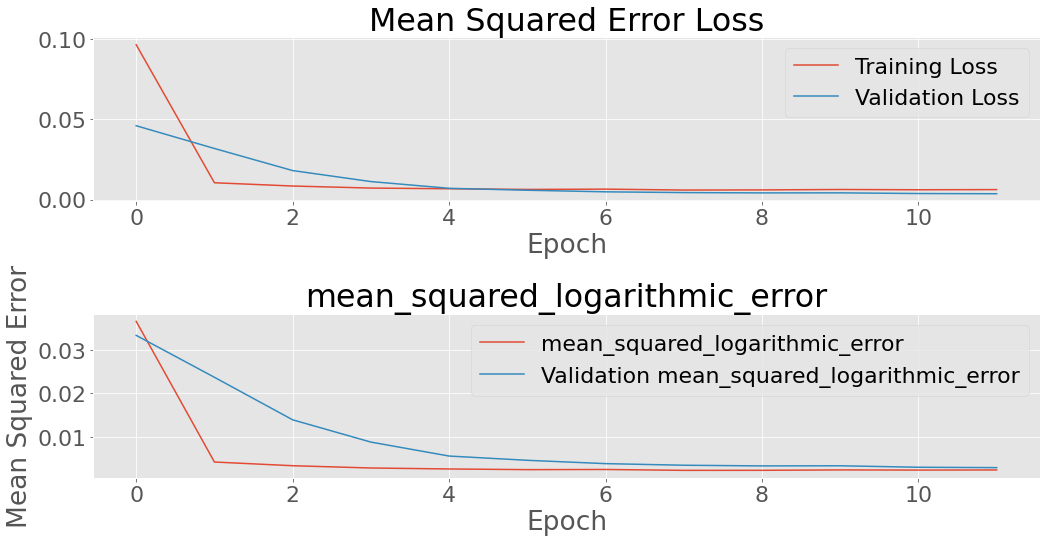

In [58]:
metrics = history.history
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(2, figsize=(15, 8))
axes[0].set_title('Mean Squared Error Loss')
axes[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['Training Loss', 'Validation Loss'])
axes[0].set_xlabel('Epoch')

axes[1].set_title(metric)
axes[1].plot(history.epoch, metrics[metric], metrics['val_'+metric])
axes[1].legend([metric, 'Validation '+metric])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Squared Error')

fig.tight_layout()
plt.show()

In [59]:
prediction = model.predict(holdout['X_test'])

In [60]:
result.keys()

dict_keys(['df', 'column_scaler', 'last_sequence', 'X_train', 'y_train', 'X_test', 'y_test', 'test_df'])

actual vs prediction r2 score

bidirectional, shuffled = 0.912

bidirectional, not shuffled = 0.817

not bi, shuffled = 0.787


In [61]:
r2_score(holdout['y_test'], prediction)

0.7875206713300801

In [62]:
predictions = np.squeeze(holdout["column_scaler"]["Close"].inverse_transform(prediction))
targets = np.squeeze(holdout["column_scaler"]["Close"].inverse_transform(np.expand_dims(holdout['y_test'], axis=0)))

In [63]:
r2_score(targets, predictions)

0.7875206682131057

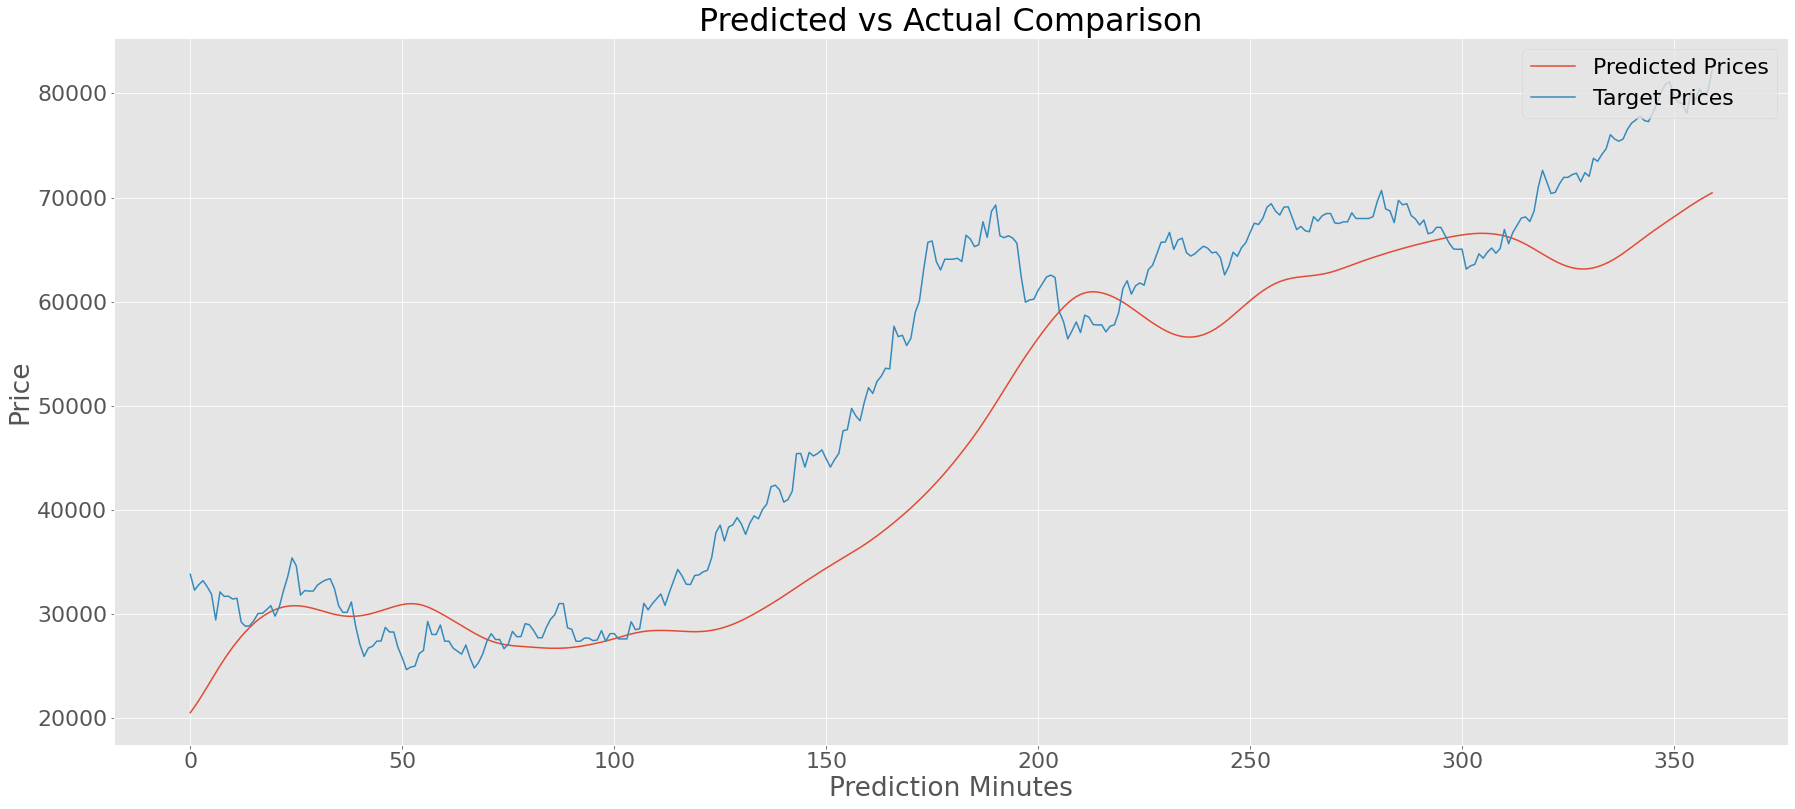

In [64]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_title("Predicted vs Actual Comparison")
ax.plot(predictions)
ax.plot(targets)
ax.legend(['Predicted Prices', 'Target Prices'], loc='upper right')

ax.set_xlabel('Prediction Minutes')
ax.set_ylabel('Price')

plt.show()

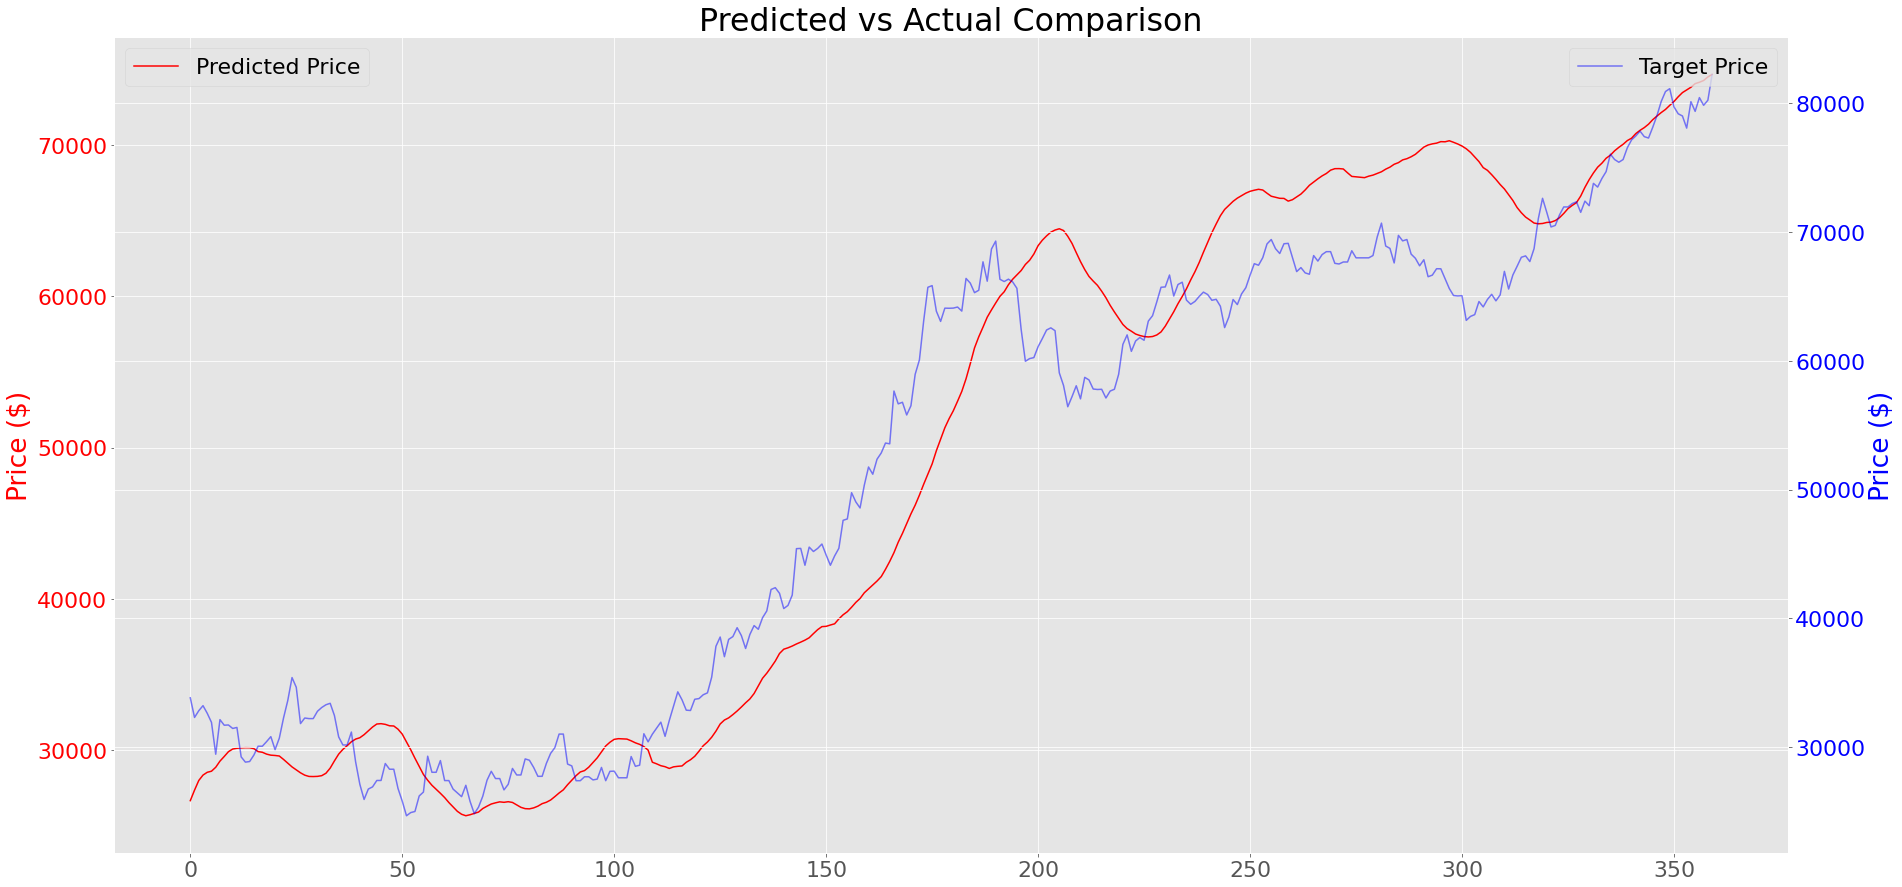

In [59]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(1, figsize=(30, 15))

ax1.plot(range(len(predictions)), predictions, color='r', label='Predicted Price')
ax1.set_ylabel('Price ($)', color ='r')
ax1.set_title("Predicted vs Actual Comparison")
ax1.tick_params(axis='y', labelcolor='r')
ax1.ticklabel_format(useOffset=False, style='plain')

ax2 = ax1.twinx()
ax2.plot(range(len(targets)), targets, color='b', alpha=0.5, label='Target Price')
ax2.set_ylabel('Price ($)', color ='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()